In [1]:
!git clone https://github.com/hoadm-net/VNews8td.git

Cloning into 'VNews8td'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 9 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 3.68 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import pandas as pd

# Đọc dữ liệu từ các tệp TSV
train_df = pd.read_csv('VNews8td/train.tsv', sep='\t', names=['description', 'label'])
val_df = pd.read_csv('VNews8td/val.tsv', sep='\t', names=['description', 'label'])
test_df = pd.read_csv('VNews8td/test.tsv', sep='\t', names=['description', 'label'])

In [3]:
# Xem qua dữ liệu
print(train_df.head(5))

                                         description    label
0  Ba Lan sa thải HLV Santos sau sáu trận. Liên đ...  thethao
1  Trữ trứng để sinh con được bao lâu?. Tôi 32 tu...  suckhoe
2  Thường xuyên đau lưng là bệnh gì?. Lưng vợ tôi...  suckhoe
3  Người mẹ bỏ chữa ung thư để tìm sự sống cho co...  doisong
4  Nguy cơ Covid đồng nhiễm virus, vi khuẩn gây b...  suckhoe


In [4]:
print(val_df.head(5))

                                         description    label
0  Ôtô tải tông ba xe máy dừng đèn đỏ. Trong khi ...   thoisu
1  Acecook Việt Nam vào Top 100 nơi làm việc tốt ...  doisong
2  Sương mù dày đặc, Nội Bài không thể tiếp nhận ...   thoisu
3  Ông Jordan lại thất bại trong cuộc bầu Chủ tịc...  thegioi
4  Mổ thành công u ung thư giáp cho người suy tim...  suckhoe


In [5]:
print(test_df.head(5))

                                         description    label
0  Công trường thi công cầu vượt sông Hương. Cầu ...   thoisu
1  Lầm tưởng nào khiến phái đẹp chăm sóc sức khỏe...  suckhoe
2  Cô gái 29 tuổi sống kiểu trẻ sơ sinh. Paigey M...  doisong
3  Hơn 30.000 người đội mưa xem hội chọi trâu. Sâ...   thoisu
4  Tình cảnh của nữ quân nhân Ukraine trên chiến ...  thegioi


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

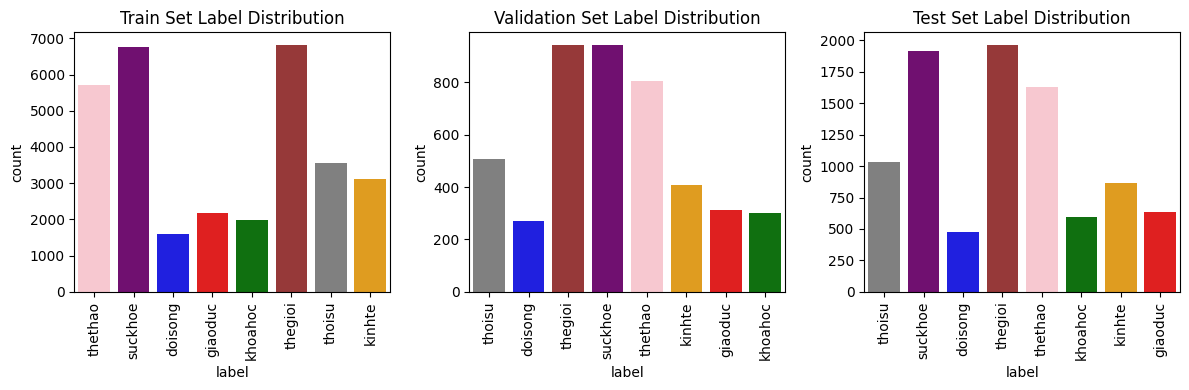

In [14]:
label_colors = {
    'doisong': 'blue',
    'giaoduc': 'red',
    'khoahoc': 'green',
    'kinhte': 'orange',
    'suckhoe': 'purple',
    'thegioi': 'brown',
    'thethao': 'pink',
    'thoisu': 'gray'
}
# Vẽ biểu đồ phân phối nhãn cho tập huấn luyện
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.countplot(x='label', data=train_df, hue='label', palette=label_colors)
plt.xticks(rotation=90)
plt.title('Train Set Label Distribution')

# Vẽ biểu đồ phân phối nhãn cho tập validation
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=val_df, hue='label', palette=label_colors)
plt.xticks(rotation=90)
plt.title('Validation Set Label Distribution')

# Vẽ biểu đồ phân phối nhãn cho tập kiểm tra
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=test_df, hue='label', palette=label_colors)
plt.xticks(rotation=90)
plt.title('Test Set Label Distribution')

plt.tight_layout()
plt.show()

<Axes: >

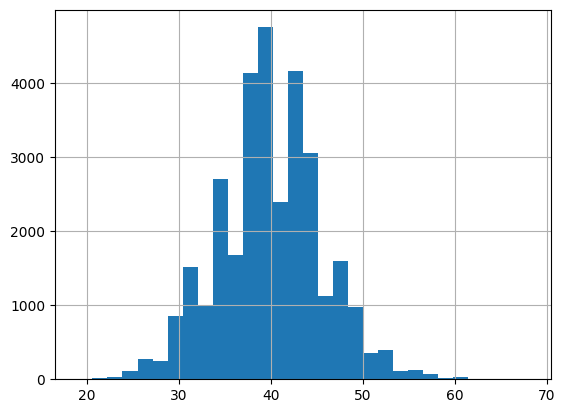

In [ ]:
seq_len = [len(i.split()) for i in train_df['description']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])
test_df['label'] = le.transform(test_df['label'])

In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

class VNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length', # Now you can safely pad sequences
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

max_length = 50
train_dataset = VNewsDataset(train_df['description'].tolist(), train_df['label'].tolist(), tokenizer, max_length)
val_dataset = VNewsDataset(val_df['description'].tolist(), val_df['label'].tolist(), tokenizer, max_length)
test_dataset = VNewsDataset(test_df['description'].tolist(), test_df['label'].tolist(), tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=8, pad_token_id=tokenizer.eos_token_id)
model = model.to(device)

epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Huấn luyện mô hình
loss_fn = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler, len(train_df))
    val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device, len(val_df))

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val loss {val_loss} accuracy {val_acc}')


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
Train loss 1.0868306798958958 accuracy 0.6295794613324932
Val loss 0.7846014646554756 accuracy 0.7412026726057906
Epoch 2/4
Train loss 0.6750919517428762 accuracy 0.7736021420696172
Val loss 0.642722017029002 accuracy 0.790423162583519
Epoch 3/4
Train loss 0.541159582140642 accuracy 0.8193101275791462
Val loss 0.5851392522984552 accuracy 0.812249443207127
Epoch 4/4
Train loss 0.465523219177661 accuracy 0.8446054496771145
Val loss 0.572682036623836 accuracy 0.8167037861915367


In [ ]:
test_acc, test_loss = eval_model(model, test_dataloader, loss_fn, device, len(test_df))
print(f'Test loss {test_loss} accuracy {test_acc}')


Test loss 0.5692941359391338 accuracy 0.8196379594075699


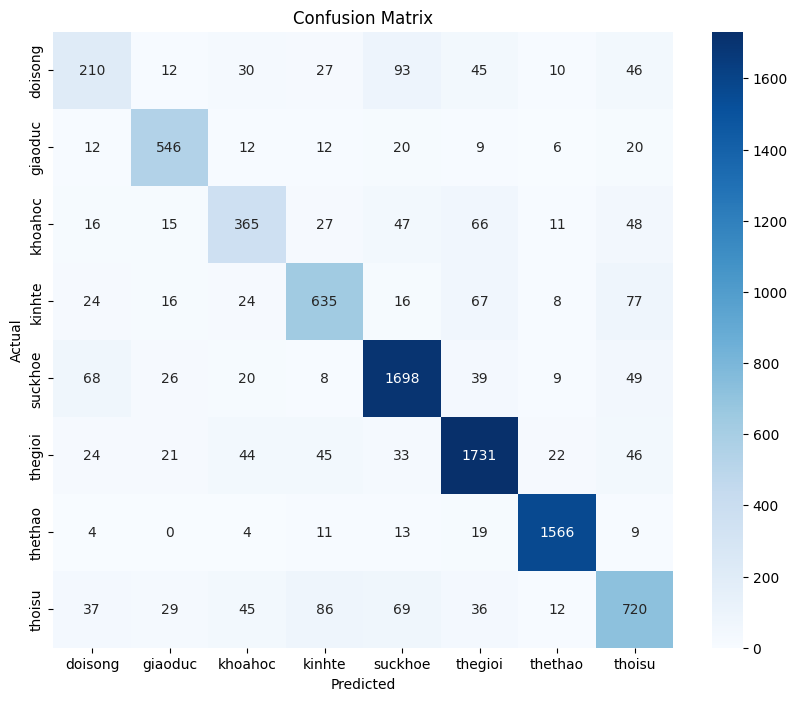

              precision    recall  f1-score   support

     doisong       0.53      0.44      0.48       473
     giaoduc       0.82      0.86      0.84       637
     khoahoc       0.67      0.61      0.64       595
      kinhte       0.75      0.73      0.74       867
     suckhoe       0.85      0.89      0.87      1917
     thegioi       0.86      0.88      0.87      1966
     thethao       0.95      0.96      0.96      1626
      thoisu       0.71      0.70      0.70      1034

    accuracy                           0.82      9115
   macro avg       0.77      0.76      0.76      9115
weighted avg       0.82      0.82      0.82      9115



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Thu thập dự đoán và nhãn thực tế từ mô hình
def get_predictions_and_labels(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds)
            true_labels.extend(labels)

    predictions = torch.stack(predictions).cpu().numpy()
    true_labels = torch.stack(true_labels).cpu().numpy()

    return predictions, true_labels

# Lấy dự đoán và nhãn thực tế
predictions, true_labels = get_predictions_and_labels(model, test_dataloader, device)

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(true_labels, predictions)
label_names = ['doisong', 'giaoduc', 'khoahoc', 'kinhte', 'suckhoe', 'thegioi', 'thethao', 'thoisu']
# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Tạo báo cáo phân loại
report = classification_report(true_labels, predictions, target_names=label_names)
print(report)


 **Đánh Giá Kết Quả**
Accuracy: Độ chính xác tổng thể của mô hình là 82%. Điều này có nghĩa là mô hình dự đoán đúng 82% các mẫu thử.

Precision, Recall và F1-Score:

+ Precision: Tỷ lệ các dự đoán đúng trong số các dự đoán được đưa ra cho mỗi lớp.

+ Recall: Tỷ lệ các dự đoán đúng trong số các mẫu thực sự thuộc về mỗi lớp.

+ F1-Score: Trung bình điều hòa của precision và recall, cung cấp một số đo duy nhất cân bằng giữa hai đại lượng này.

# Chi Tiết Các Lớp:

doisong (Đời sống):

- Precision: 0.53
- Recall: 0.44
- F1-Score: 0.48
- Hiệu suất trên lớp "Đời sống" khá thấp, đặc biệt là recall. Điều này cho thấy mô hình bỏ sót nhiều mẫu thuộc lớp này.

giaoduc (Giáo dục):

- Precision: 0.82
- Recall: 0.86
- F1-Score: 0.84
- Hiệu suất trên lớp "Giáo dục" rất tốt, với cả precision và recall đều cao.

khoahoc (Khoa học):

- Precision: 0.67
- Recall: 0.61
- F1-Score: 0.64
- Hiệu suất trên lớp "Khoa học" trung bình, có thể cải thiện hơn.

kinhte (Kinh tế):

- Precision: 0.75
- Recall: 0.73
- F1-Score: 0.74
- Hiệu suất tốt trên lớp "Kinh tế".

suckhoe (Sức khỏe):

- Precision: 0.85
- Recall: 0.89
- F1-Score: 0.87
- Hiệu suất rất tốt trên lớp "Sức khỏe".

thegioi (Thế giới):

- Precision: 0.86
- Recall: 0.88
- F1-Score: 0.87
- Hiệu suất rất tốt trên lớp "Thế giới".

thethao (Thể thao):

- Precision: 0.95
- Recall: 0.96
- F1-Score: 0.96
- Hiệu suất tuyệt vời trên lớp "Thể thao".

thoisu (Thời sự):

- Precision: 0.71
- Recall: 0.70
- F1-Score: 0.70
- Hiệu suất trung bình trên lớp "Thời sự".

# Tổng Kết
- Mô hình của bạn hoạt động rất tốt trên một số lớp như "Giáo dục", "Sức khỏe", "Thế giới", và "Thể thao", nhưng lại có hiệu suất kém hơn trên các lớp như "Đời sống" và "Khoa học".
- Hiệu suất của "Đời sống" và "Khoa học" thấp là do sự mất cân bằng trong tập dữ liệu. Tuy nhiên "Giáo dục" lại cao mặc dù lượng dữ liệu thấp có thể là do việc phân biệt dễ dàng hơn so với các lớp khác.